In [34]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import re
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from typing import List, Tuple, Any
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [37]:
class SpamDetectorTraditional():
    def __init__(self, word_indices_path: str) -> None:
        with open(word_indices_path, "rb") as f:
            word_indices = pkl.load(f)
        self.feature_dim = len(word_indices)

        self.word_to_index = {word: i for i, word in enumerate(word_indices)}
        self.index_to_word = {i: word for i, word in enumerate(word_indices)}
        
    def toFeature(self, email: str) -> np.array:
        feature = np.zeros(self.feature_dim)
        content = str(email).lower()
        content = re.sub(r'\W', ' ', content)

        words = content.split()
        
        word_counter = Counter(words)
        for word, count in word_counter.items():
            if word in self.word_to_index:
                index = self.word_to_index[word]
                feature[index] = count

        return feature
    
    def preprocess(self, email_dataframe: pd.DataFrame) -> np.ndarray:
        features = np.zeros((len(email_dataframe), self.feature_dim))
        labels = np.array(email_dataframe["label"])

        for i in tqdm(range(len(email_dataframe))):
            email = email_dataframe.iloc[i]["body"]
            features[i] = self.toFeature(email)

        return features, labels
    
    def train(self, email_dataframe: pd.DataFrame, model_class: Any, model_save_path: str, **model_params) -> None:
        print("Training...")
        features, labels = self.preprocess(email_dataframe)
        model = model_class(**model_params)
        model.fit(features, labels)
        with open(model_save_path, "wb") as f:
            pkl.dump(model, f)

        return model
    
    def eval(self, email_dataframe: pd.DataFrame, model: Any) -> np.ndarray:
        print("Evaluating...")
        features, labels = self.preprocess(email_dataframe)
        
        # Output accuracy, precision, recall, F1
        pred_labels = model.predict(features)
        accuracy = accuracy_score(labels, pred_labels)
        precision = precision_score(labels, pred_labels)
        recall = recall_score(labels, pred_labels)
        f1 = f1_score(labels, pred_labels)
        confusion = confusion_matrix(labels, pred_labels)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1: {f1}")
        
        # Plot confusion matrix with numbers and axis labels
        plt.imshow(confusion, cmap='binary', interpolation='None')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.xticks([0, 1], ["ham", "spam"])
        plt.yticks([0, 1], ["ham", "spam"])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, confusion[i, j], ha='center', va='center', color='red')
        plt.show()

In [53]:
def mergeEmailDatasets(csv_paths: List[str], body_column_names: List[str], label_column_names: List[str]) -> pd.DataFrame:
    data_frames = []
    for i in range(len(csv_paths)):
        dataframe = pd.read_csv("SpamAssasin.csv")[[body_column_names[i], label_column_names[i]]]
        dataframe.rename(columns={body_column_names[i]: "body", label_column_names[i]: "label"})
        dataframe["label"] = dataframe["label"].apply(lambda x: int(x in ["spam", "1", 1]))
        data_frames.append(dataframe)
    if len(data_frames) == 1:
        return data_frames[0]
    return pd.concat(data_frames)

Training...


100%|██████████| 5809/5809 [00:02<00:00, 2904.05it/s]


Evaluating...


100%|██████████| 1565/1565 [00:00<00:00, 2288.91it/s]

Accuracy: 0.6939297124600639
Precision: 1.0
Recall: 0.6939297124600639
F1: 0.8193134666163712


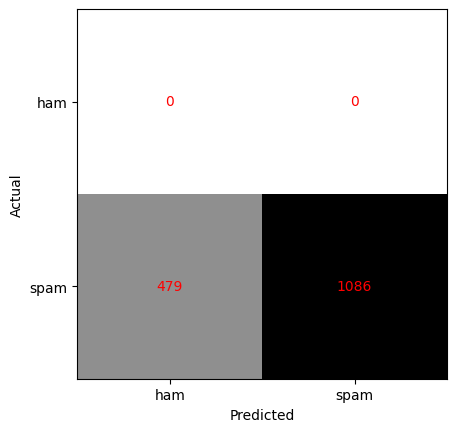

In [42]:
trainer = SpamDetectorTraditional("word_indices.pkl")
train_set = pd.read_csv("SpamAssasin.csv")[["body", "label"]]
model = trainer.train(train_set, MultinomialNB, "NaiveBayes.pkl")

test_set = pd.read_csv("Nazario.csv")[["body", "label"]]
trainer.eval(test_set, model)